<a href="https://colab.research.google.com/github/opt1cx/APP-miniproject/blob/main/Sharemarket_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE

from google.colab import files

In [ ]:
uploaded = files.upload()
df = pd.read_json('assessment_dataset.json')
df.head()


Saving assessment_dataset.json to assessment_dataset.json


,orderblock_timestamp,timeframe,entry_timestamp,exit_timestamp,time_of_day_ob,day_of_week_number,orderblock_type,impulse_percentage,impulse_window,zone_high,...,30m_market_shift_detected,1h_trend_swings,4h_trend_swings,1d_trend_swings,4h_trend_ob,4h_trend_strength_ob,1d_trend_ob,1d_trend_strength_ob,30m_trend_direction_swings,1h_trend_direction_swings
0,2020-01-02T21:45:00,15,2020-01-03T10:00:00,2020-01-03T10:15:00,21:45,3,bearish,-1.9968,3,7115.45,...,False,neutral,neutral,neutral,undefined,NaN,undefined,NaN,NaN,NaN
1,2020-01-07T03:15:00,15,2020-03-12T07:45:00,2020-03-12T08:00:00,03:15,1,bullish,1.8462,3,7579.00,...,False,uptrend,neutral,neutral,uptrend,33.021852,undefined,NaN,downtrend,NaN
2,2020-01-07T04:45:00,15,2020-01-07T21:15:00,2020-01-07T21:30:00,04:45,1,bullish,1.5231,3,7764.30,...,False,uptrend,neutral,neutral,uptrend,33.021852,undefined,NaN,NaN,NaN
3,2020-01-07T21:15:00,15,2020-01-09T22:30:00,2020-01-10T01:00:00,21:15,1,bullish,1.7877,3,7794.73,...,True,neutral,neutral,neutral,uptrend,40.480596,undefined,NaN,neutral,NaN
4,2020-01-07T23:15:00,15,2020-01-09T01:30:00,2020-01-09T02:00:00,23:15,1,bullish,1.6898,3,7947.84,...,False,neutral,neutral,neutral,uptrend,42.097112,undefined,NaN,NaN,NaN


#EDA

In [ ]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2015 entries, 0 to 2014
Data columns (total 87 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   orderblock_timestamp               2015 non-null   object 
 1   timeframe                          2015 non-null   int64  
 2   entry_timestamp                    2015 non-null   object 
 3   exit_timestamp                     2015 non-null   object 
 4   time_of_day_ob                     2015 non-null   object 
 5   day_of_week_number                 2015 non-null   int64  
 6   orderblock_type                    2015 non-null   object 
 7   impulse_percentage                 2015 non-null   float64
 8   impulse_window                     2015 non-null   int64  
 9   zone_high                          2015 non-null   float64
 10  zone_low                           2015 non-null   float64
 11  entry                              2015 non-null   float

,0
orderblock_timestamp,0
timeframe,0
entry_timestamp,0
exit_timestamp,0
time_of_day_ob,0
...,...
4h_trend_strength_ob,1
1d_trend_ob,0
1d_trend_strength_ob,23
30m_trend_direction_swings,1634


In [ ]:
# Capping to limit the outliers
q_high_volume = df['orderblock_volume'].quantile(0.99)
df.loc[df['orderblock_volume'] > q_high_volume, 'orderblock_volume'] = q_high_volume

# Capping extreme outliers for displacement_strength
q_high_displacement = df['displacement_strength'].quantile(0.99)
df.loc[df['displacement_strength'] > q_high_displacement, 'displacement_strength'] = q_high_displacement

# Capping swing_percentage_difference
q_low_swing = df['swing_percentage_difference'].quantile(0.01)
q_high_swing = df['swing_percentage_difference'].quantile(0.99)

df['swing_percentage_difference'] = df['swing_percentage_difference'].clip(lower=q_low_swing, upper=q_high_swing)


# Capping 30m_imbalance_prct
q_low_imb = df['30m_imbalance_prct'].quantile(0.01)
q_high_imb = df['30m_imbalance_prct'].quantile(0.99)

df['30m_imbalance_prct'] = df['30m_imbalance_prct'].clip(lower=q_low_imb, upper=q_high_imb)


# Applying log transformation to reduce right skew and stabilize variance
df['orderblock_volume'] = np.log1p(df['orderblock_volume'])
df['displacement_strength'] = np.log1p(df['displacement_strength'])

# Checking class balance for outcome variable
print("Class Balance (outcome):")
print(df['outcome'].value_counts(normalize=True))


Class Balance (outcome):
outcome
profit    0.62134
loss      0.37866
Name: proportion, dtype: float64


This block handles outliers by capping values at the 99th percentile for selected features and applies log transformations to reduce right skewness. It also checks the class distribution of the target variable to assess imbalance.



In [ ]:
# Numerical columns for distribution and boxplots
numerical_cols = [
    'orderblock_wick_ratio',
    'orderblock_volume',
    'swing_percentage_difference',
    'displacement_strength',
    '30m_imbalance_prct'
]

# Categorical columns for countplots
categorical_cols = ['1h_confirmation', '4h_trend_ob']


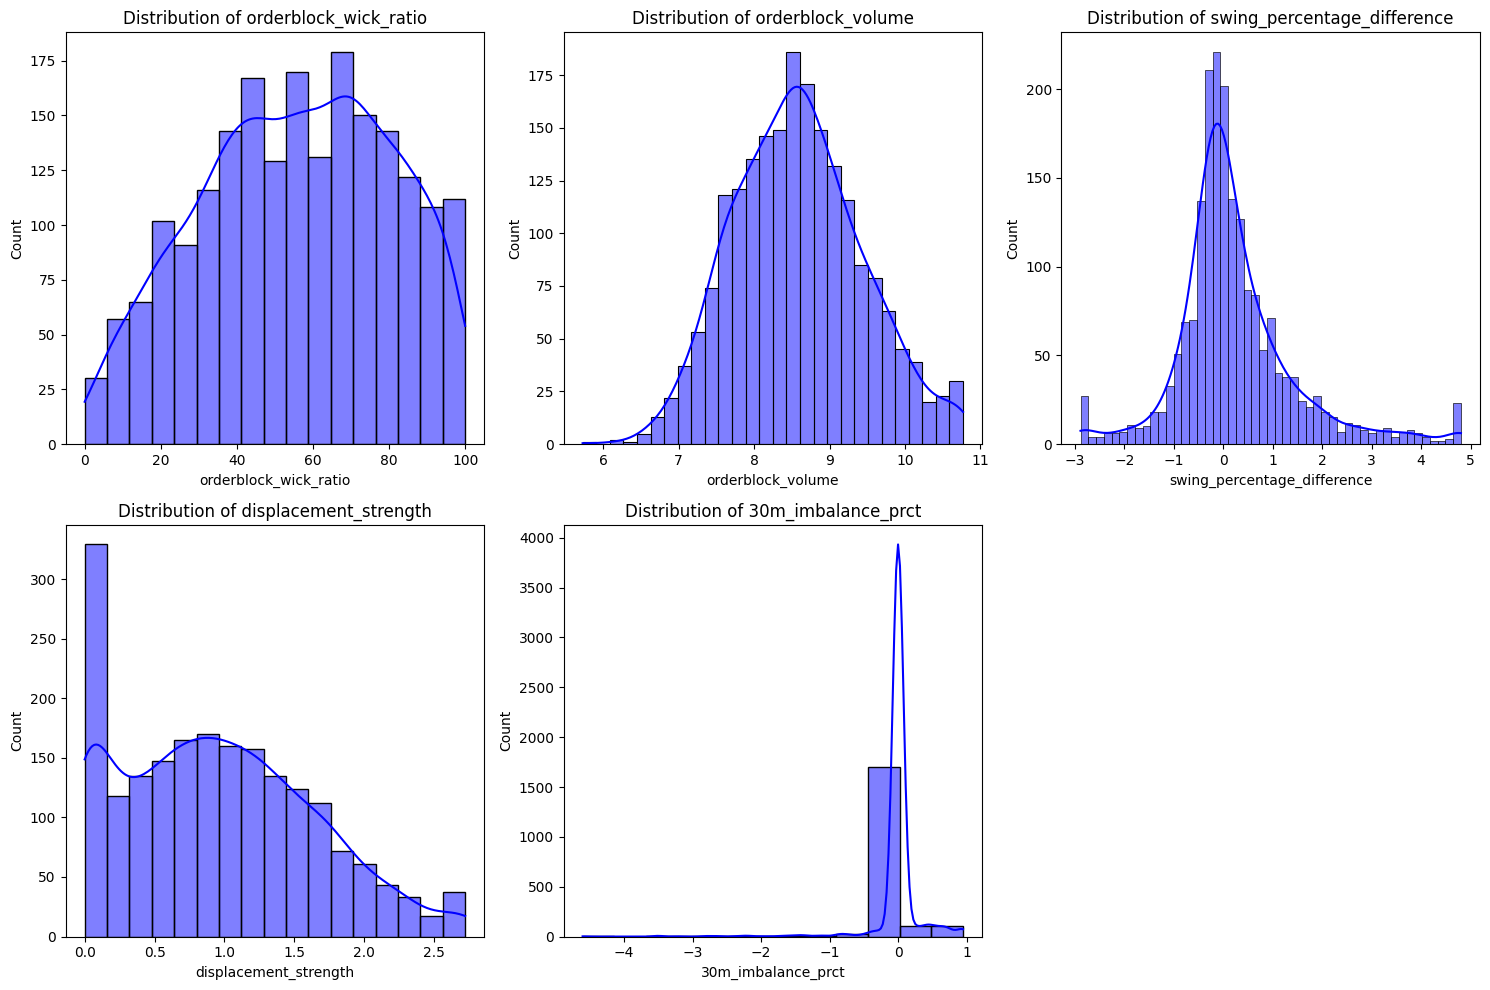

In [ ]:
plt.figure(figsize=(15, 10))

for idx, col in enumerate(numerical_cols):
    plt.subplot(2, 3, idx+1)
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()


| **Feature**                   | **KDE Insight**                                                 |
| ----------------------------- | --------------------------------------------------------------- |
| orderblock\_wick\_ratio       | Evenly spread, no dominant peak, values are well distributed.   |
| orderblock\_volume            | Strong right-skew with long tail, heavy outliers detected.      |
| swing\_percentage\_difference | Centered around zero, symmetrical, behaves normally.            |
| displacement\_strength        | Right-skewed with long tail, extreme values present.            |
| 30m\_imbalance\_prct          | Sharp peak at zero, low variability, most values cluster there. |


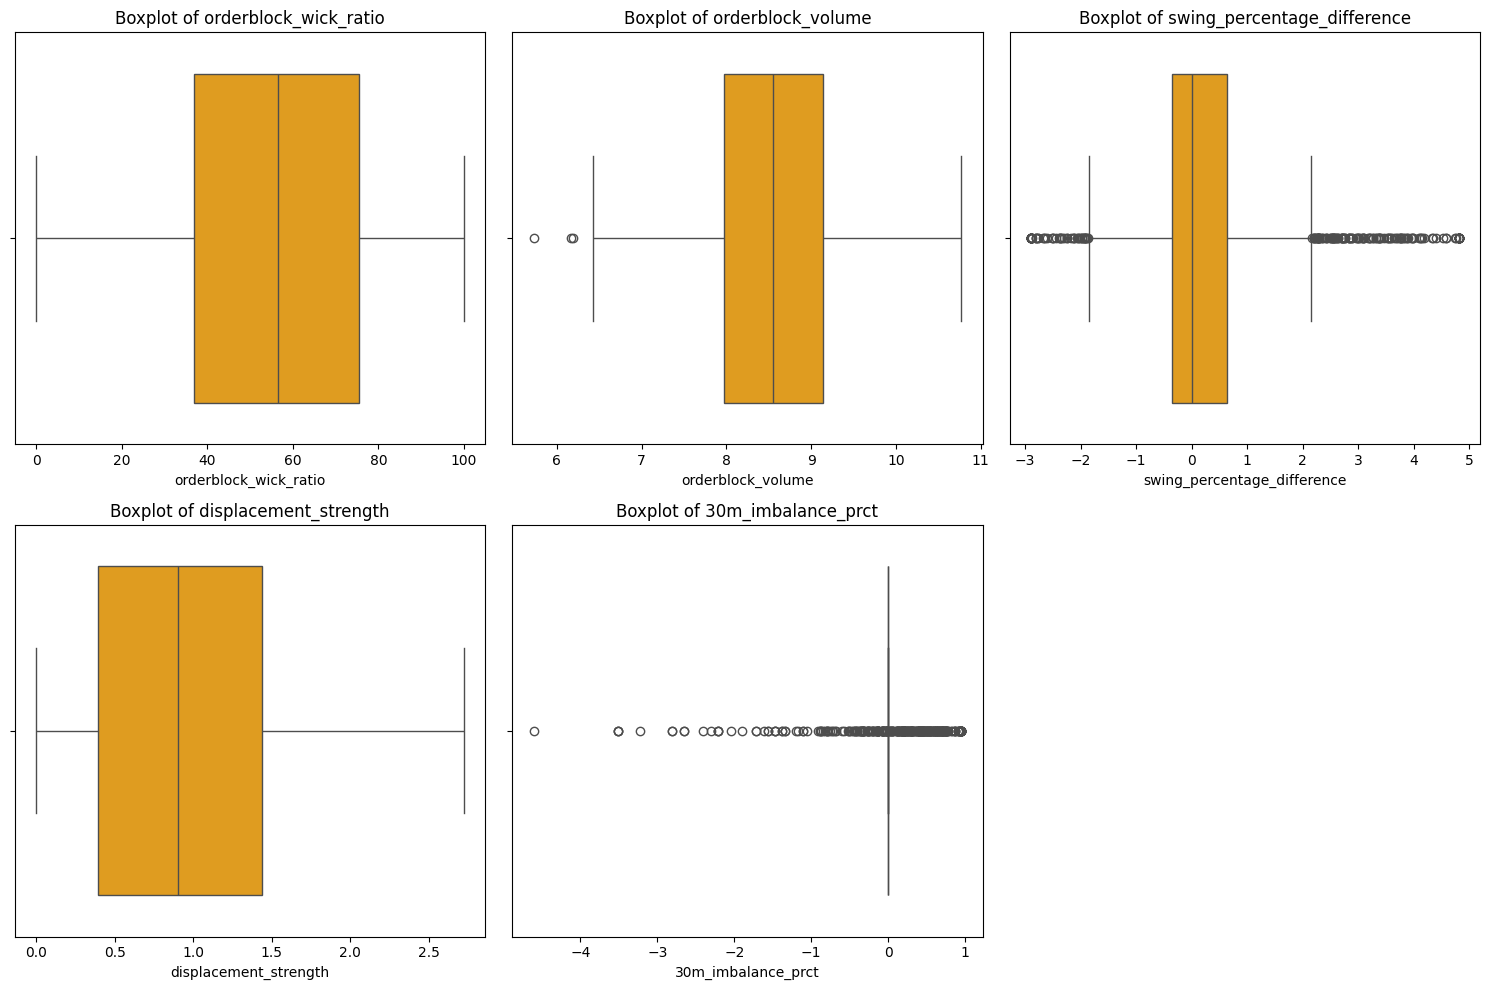

In [ ]:
plt.figure(figsize=(15, 10))

for idx, col in enumerate(numerical_cols):
    plt.subplot(2, 3, idx+1)
    sns.boxplot(x=df[col], color='orange')
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()


| **Feature**                   | **Boxplot Insight**                                             |
| ----------------------------- | --------------------------------------------------------------- |
| orderblock\_wick\_ratio       | Clean spread, no significant outliers, good range.              |
| orderblock\_volume            | Heavy outliers far above upper whisker, confirms skewness.      |
| swing\_percentage\_difference | Few mild outliers, mostly symmetric, acceptable range.          |
| displacement\_strength        | Clear presence of extreme outliers, aligns with histogram skew. |
| 30m\_imbalance\_prct          | Tight clustering near zero, few mild outliers, low variability. |



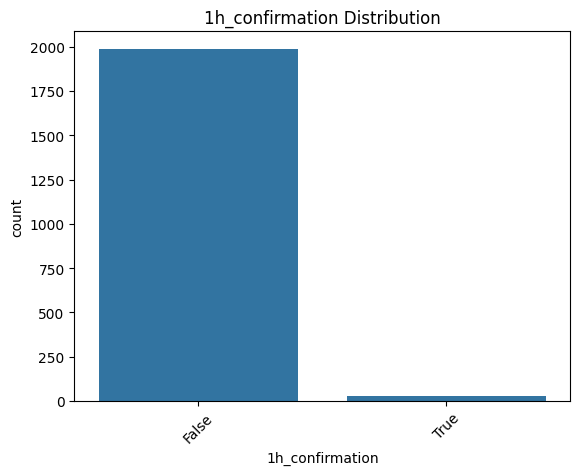

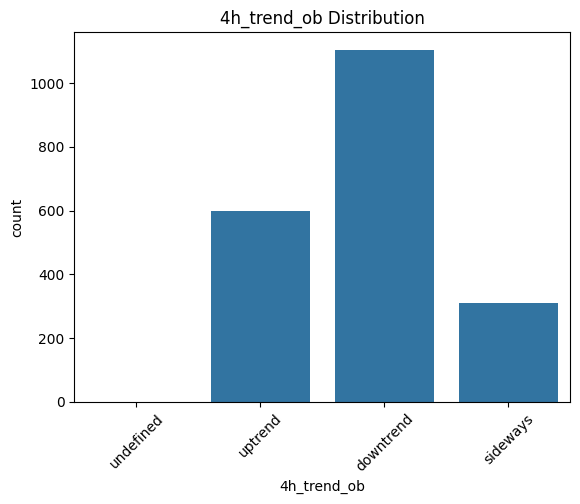

In [ ]:
for col in categorical_cols:
    sns.countplot(data=df, x=col)
    plt.title(f"{col} Distribution")
    plt.xticks(rotation=45)
    plt.show()


Downtrend dominates, followed by uptrend; undefined and sideways are less common.
Highly imbalanced, very few True values compared to False


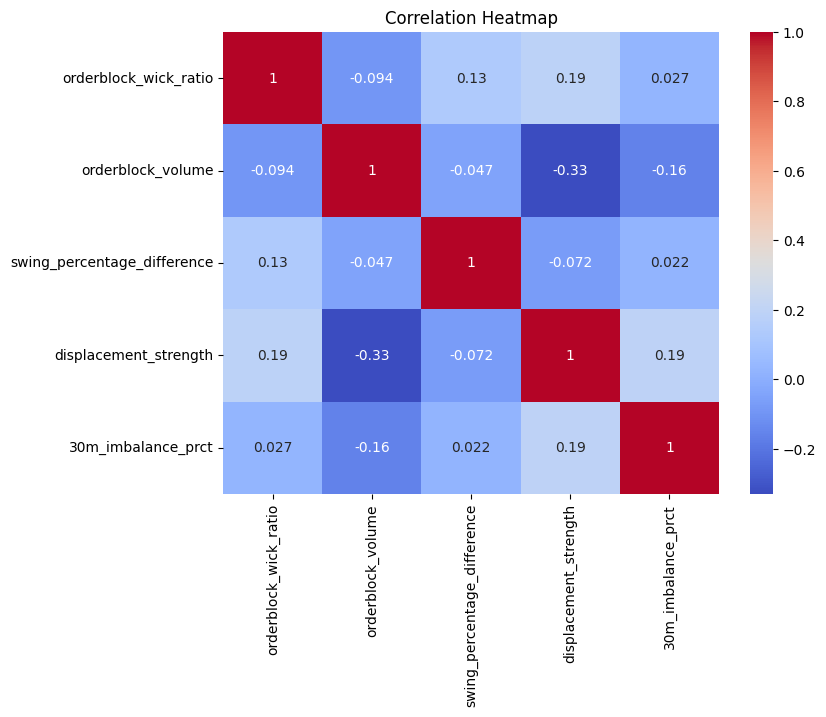

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


Most features show weak to moderate correlations, minimal multicollinearity risk, but related pairs (like displacement and imbalance) may influence modeling.

#Feature Engineering & Modeling

In [ ]:
columns_needed = [
    'orderblock_wick_ratio',
    'orderblock_volume',
    'swing_percentage_difference',
    'displacement_strength',
    '1h_confirmation',
    '30m_imbalance_prct',
    '4h_trend_ob',
    'outcome'
]

df = df[columns_needed]

In [ ]:
df['1h_confirmation'] = df['1h_confirmation'].astype(int)
df = pd.get_dummies(df, columns=['4h_trend_ob'], prefix='4h_trend')

This block ensures 1h_confirmation is treated as an integer feature and applies one-hot encoding to 4h_trend_ob, converting it into multiple binary columns for better compatibility with machine learning models.



In [ ]:
def wick_strength_category(ratio):
    if ratio < 20:
        return 'Low'
    elif ratio < 50:
        return 'Medium'
    else:
        return 'High'

df['wick_strength_category'] = df['orderblock_wick_ratio'].apply(wick_strength_category)
df = pd.get_dummies(df, columns=['wick_strength_category'], prefix='wick_strength')

volume_median = df['orderblock_volume'].median()
df['high_volume_flag'] = (df['orderblock_volume'] > volume_median).astype(int)

df['displacement_to_swing_ratio'] = df['displacement_strength'] / (df['swing_percentage_difference'] + 1e-6)

df['outcome'] = df['outcome'].map({'profit': 1, 'loss': 0})
df.head()

,orderblock_wick_ratio,orderblock_volume,swing_percentage_difference,displacement_strength,1h_confirmation,30m_imbalance_prct,outcome,4h_trend_downtrend,4h_trend_sideways,4h_trend_undefined,4h_trend_uptrend,wick_strength_High,wick_strength_Low,wick_strength_Medium,high_volume_flag,displacement_to_swing_ratio
0,58.642857,7.242074,0.81,2.193886,0,0.00,0,False,False,True,False,True,False,False,0,2.708497
1,91.808511,7.716835,0.67,1.456287,0,0.51,1,False,False,False,True,True,False,False,0,2.173559
2,74.732495,8.780238,2.82,0.000000,0,0.00,1,False,False,False,True,True,False,False,1,0.000000
3,56.302234,8.424340,-0.91,1.144223,0,0.51,1,False,False,False,True,True,False,False,0,-1.257389
4,80.365009,7.504671,2.22,1.348073,0,0.00,1,False,False,False,True,True,False,False,0,0.607240


This block engineers multiple features to enrich the dataset. It categorizes orderblock_wick_ratio into ordinal categories, applies one-hot encoding, creates a binary flag for high volume based on the median, generates a ratio feature between displacement and swing percentage, and converts the target variable to binary format. Finally, the head of the updated DataFrame is displayed for inspection.



In [ ]:
X = df.drop('outcome', axis=1)

# Keep only numeric columns
X = X.select_dtypes(include=[np.number])

y = df['outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


This block prepares the data for model training. It separates features and target, filters to retain only numeric columns, and performs a stratified train-test split to ensure balanced class distribution, with 70% of the data for training and 30% for testing.


In [ ]:
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


This block handles missing values by applying median imputation to the dataset. The imputer is fitted on the training data to prevent data leakage and then consistently applied to both training and testing sets for reliable preprocessing.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


This block standardizes the features by scaling them to have zero mean and unit variance, ensuring all features contribute equally during model training.

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


This block applies SMOTE to generate synthetic samples for the minority class, ensuring balanced class distribution in the training data.

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(class_weight='balanced', random_state=42)

This block trains a Random Forest classifier with 100 trees and balanced class weights to handle class imbalance and build a robust predictive model.

In [ ]:
y_pred = rf.predict(X_test_scaled)

print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.39      0.37      0.38       229
           1       0.63      0.65      0.64       376

    accuracy                           0.54       605
   macro avg       0.51      0.51      0.51       605
weighted avg       0.54      0.54      0.54       605

Confusion Matrix:
[[ 84 145]
 [131 245]]


/tmp/ipython-input-19-2703601949.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(5), x='Importance', y='Feature', palette='viridis')


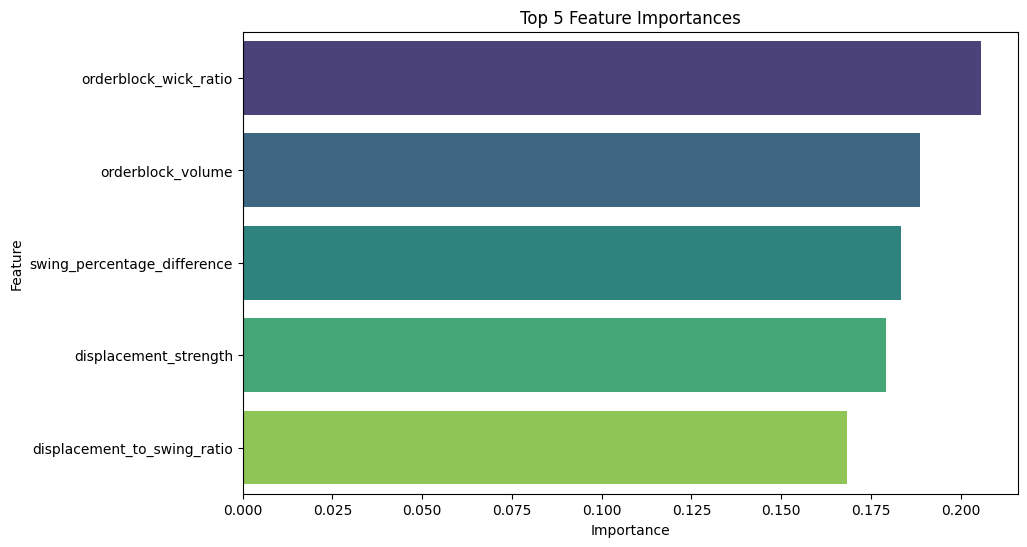

In [ ]:
importances = rf.feature_importances_
feature_names = X.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp_df.head(5), x='Importance', y='Feature', palette='viridis')
plt.title("Top 5 Feature Importances")
plt.show()


The feature importance plot shows that trend_strength_entry is the most influential feature for predicting the outcome, followed by orderblock_size_percentage, imbalance_percentage, 1d_trend_strength_ob, and displacement_strength. This insight helps me understand which technical features have the most predictive power and can guide feature selection or domain interpretation.